<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Feature Selection </h2>	


<h4> In this section, we would like you to select between 15 and 20 features to focus your model on. This will require significant explatoratory research. The first one is already implemented for you, and the next two are pre-specified.  </h4>

In [1]:
import pandas as pd
import numpy as np
import skimage.io as io
import cv2 as cv
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def normalize(image):
    """
    Given an image (numpy ndarray) check if it has just one color channel
    (black/white). If yes, return the same channel intesities copied in 
    all three RGB color channels.
    """
    if len(image.shape) == 2:
        temp = np.zeros((image.shape[0], image.shape[1], 3))
        for i in range(3):
            temp[:,:,i] = image
        image = temp
    return image


def red_avg(image):
    """
    Returns the average intesity of the red-channel for the given image
    (numpy ndarray)
    """
    return np.mean(image[:, :, 0])


def green_avg(image):
    """
    Returns the average intesity of the green-channel for the given image
    (numpy ndarray)
    """
    return np.mean(image[:, :, 1])


def blue_avg(image):
    """
    Returns the average intesity of the blue-channel for the given image
    (numpy ndarray)
    """
    return np.mean(image[:, :, 2])

def argmax(image):
    """
    Given image (numpy ndarray) return the fraction times when that channel
    has maximum intensity in the image
    """
    orig = np.zeros(3)
    a = np.argmax(image, axis = 2)
    vals, counts = np.unique(a, return_counts=True)
    for i in range(3):
        if i in vals:
            orig[i] = counts[np.where(vals == i)]
    percent_max = orig/np.sum(orig)
    
    # handling special case when length not equal to 3
    if len(percent_max) != 3:
        print('Warning! Percent max length is not 3')
        
    return percent_max

def crop(image):
    """
    Given an image (numpy ndarray), return a central patch of the image such 
    that length and bredth of the patch is half the previous one
    """
    m, n, k = image.shape
    patch_min = int(m/4)
    patch_max = int(3*m/4)
    cropped = image[patch_min:patch_max, patch_min:patch_max, :]
    
    return cropped


def contrast(image):
    """
    Given an image (numpy ndarray), return the contrast of the image. 
    Contrast is defined as the mean of the per-channel contrast, where
    per-channel contrast is defined as range of intensities in that channel
    divided by maximum possible range. 
    """
    
    vals = np.zeros(3)
    for i in range(3):
        vals[i] = (np.max(image[:, :, i]) - np.min(image[:, :, i]))
    
    return np.mean(vals)

def edges(image, threshold_low = 100, threshold_high = 200):
    """
    Given an image (numpy ndarray), return the fraction of number of pixels
    that are part of an 'edge' according to the Canny edge detection algorithm.
    """
    # converting from float to uint8 to keep cv2 happy!!
    edges_image = cv.Canny(image.astype(np.uint8), threshold_low, threshold_high)
    
    vals, counts = np.unique(edges_image, return_counts=True)
    
    if len(counts)<2:
        return 1.0
    else:
        return counts[1]/sum(counts)

Define more features above, performing any EDA research below. We expect all external sources sited, and a couple significant different graphs indicating some form of EDA. 

<h4> DataFrame Creation </h4>

In [3]:
def feature_frame(df, image_field="image"):
    """
    Given a DataFrame and the field corresponding to images (numpy ndarray)
    return a dataframe with all the required features added to the dataframe
    as series. If an above function returned a vector of 3 values (e.g
    per channel metrics, feature_frame splits them into separate columns
    to preserve scalar features).
    
    """
    df[image_field] = df[image_field].apply(normalize)

    df["red"] = df[image_field].apply(red_avg)
    df["green"] = df[image_field].apply(green_avg)
    df["blue"] = df[image_field].apply(blue_avg)
    df["argmax"] = df[image_field].apply(argmax)
    df[["argmax_r","argmax_g","argmax_b"]] = pd.DataFrame(
        df.argmax.values.tolist(), index= df.index)
    df["contrast"] = df[image_field].apply(contrast)
    df["edge"] = df[image_field].apply(edges)

    df["cropped"] = df[image_field].apply(crop)
    df["red_crop"] = df["cropped"].apply(red_avg)
    df["green_crop"] = df["cropped"].apply(green_avg)
    df["blue_crop"] = df["cropped"].apply(blue_avg)
    df["argmax_crop"] = df["cropped"].apply(argmax)
    df[["argmax__crop_r","argmax_crop_g","argmax_crop_b"]] = pd.DataFrame(
        df.argmax_crop.values.tolist(), index= df.index)
    df["contrast_crop"] = df["cropped"].apply(contrast)
    df["edge_crop"] = df["cropped"].apply(edges)
    
    df = df.drop(labels = [image_field,  'cropped','argmax', 'argmax_crop'],\
                 axis = 1) #'filename',

    return df

In [4]:
starting_data = pd.read_pickle("./starting_data_part1.pkl")
train_df = feature_frame(starting_data, image_field="image")
train_df.head()

,class,filename,aspect,red,green,blue,argmax_r,argmax_g,argmax_b,contrast,edge,red_crop,green_crop,blue_crop,argmax__crop_r,argmax_crop_g,argmax_crop_b,contrast_crop,edge_crop
0,0,airplanes_0001.jpg,2.426829,183.357049,176.758482,149.242033,0.572327,0.421021,0.006653,254.463664,0.113464,161.131365,160.474151,137.006400,0.536377,0.460449,0.003174,250.598267,0.193604
1,0,airplanes_0002.jpg,2.179348,210.781639,189.322828,164.848389,0.971802,0.028198,0.000000,249.801636,0.056641,172.329463,127.098600,104.797017,0.984375,0.015625,0.000000,239.890218,0.149658
2,0,airplanes_0003.jpg,2.381818,169.915943,147.578112,111.457837,0.705322,0.056702,0.237976,253.397135,0.126892,155.995922,106.718251,49.301164,0.809326,0.065430,0.125244,220.446019,0.228027
3,0,airplanes_0004.jpg,2.311765,152.404667,132.895747,78.073232,0.835449,0.161743,0.002808,253.534108,0.159851,146.875142,103.978308,37.956971,0.943848,0.052734,0.003418,247.106567,0.236084
4,0,airplanes_0005.jpg,2.244318,147.112763,150.219843,86.000939,0.404968,0.515442,0.079590,254.519206,0.169128,100.401541,102.504867,46.679292,0.262695,0.493408,0.243896,253.630859,0.244629


In [5]:
testing_data = pd.read_pickle("./testing_data_part1.pkl")
test_df = feature_frame(testing_data, image_field="image")
test_df.head()

,aspect,red,green,blue,argmax_r,argmax_g,argmax_b,contrast,edge,red_crop,green_crop,blue_crop,argmax__crop_r,argmax_crop_g,argmax_crop_b,contrast_crop,edge_crop
0,0.666667,105.836632,106.750862,105.395693,0.295654,0.232788,0.471558,249.498861,0.245728,87.272086,91.504901,99.986158,0.151367,0.145752,0.702881,245.409831,0.237793
1,1.897638,144.729852,147.530245,133.920890,0.304810,0.664917,0.030273,252.478907,0.252563,171.761988,172.790249,162.152330,0.443359,0.520020,0.036621,248.381083,0.208984
2,0.853868,133.698556,123.886615,118.594143,0.756958,0.003906,0.239136,252.877604,0.176636,103.625295,91.338772,79.451448,0.937500,0.005615,0.056885,239.731903,0.142578
3,1.524194,96.665471,83.594112,85.548723,0.681824,0.028381,0.289795,240.656718,0.056519,101.383417,89.400274,90.226693,0.632812,0.014893,0.352295,237.577148,0.095947
4,0.665714,23.228450,40.593328,46.885397,0.000427,0.163940,0.835632,218.555461,0.071960,38.244846,56.927569,65.906044,0.000000,0.072510,0.927490,217.192179,0.113281


<h4> Graphs and EDA </h4>

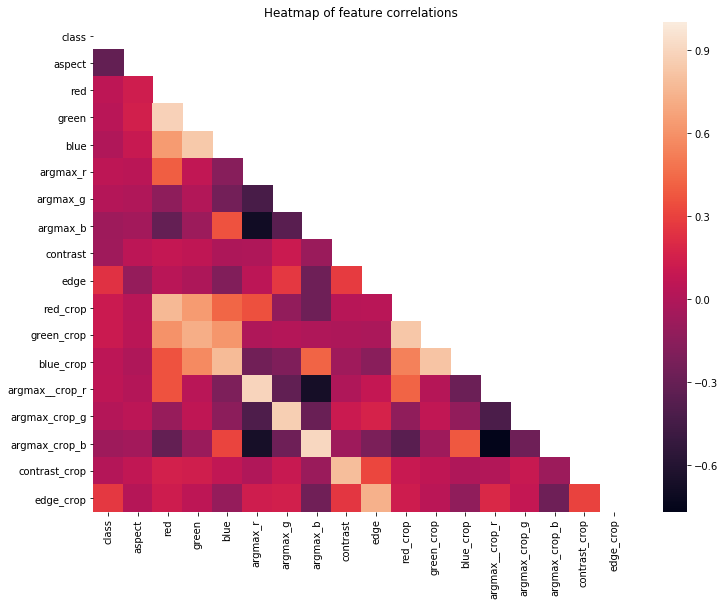

In [6]:
corr = train_df.corr()
plt.figure(figsize=(12,9))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask)
plt.title("Heatmap of feature correlations")
plt.savefig("figs/feature_correlation.png", bbox_inches='tight')

This plot is interesting because it helps demonstrate how some of our features may be correlated when we're using
machine learning. We generally would want to avoid a lot of correlation, so this helps us understand if there's correlation other than what we expect. There are some high correlations between the different combinations of argmax values which makes sense -- as one goes up the others must come down. Similarly we see high correlation between
the average intensities of the different channels as these are also in an inverse relationship. One good thing is the fact that we don't see much correlation between seemingly uncorrelated features, which is exactly what we want in this case. 

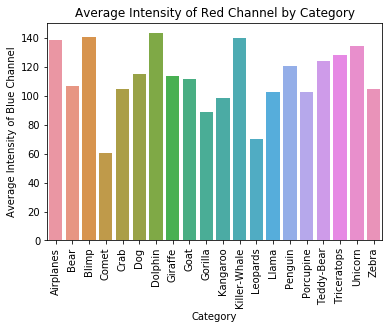

In [7]:
category_list = ["Airplanes","Bear","Blimp","Comet","Crab","Dog","Dolphin",
                     "Giraffe","Goat","Gorilla","Kangaroo","Killer-Whale",
                     "Leopards","Llama","Penguin","Porcupine","Teddy-Bear",
                     "Triceratops","Unicorn","Zebra"]
new_df = train_df.groupby('class').agg('mean').reset_index()
sns.barplot(x = 'class', y = 'blue', data = new_df)
plt.xticks(range(len(category_list)), category_list, rotation = 90)
plt.xlabel('Category')
plt.ylabel('Average Intensity of Blue Channel')
plt.title('Average Intensity of Red Channel by Category')
plt.savefig("figs/intensity_red.png", bbox_inches="tight")

The above plot demonstrates how our intuition regarding color changes was correct. We see above that the average
intensity of the blue channel ranges widely, and we can see that animals that live in the ocean, like whales and
dolphins, have the highest blue intensity. Lower intensities can be seen for animals like the gorilla and leopards
which would be primarily in non-blue habitats. Because of the amount of variance between classes here, we can say
that this would definitely be a useful feature for our ML models.

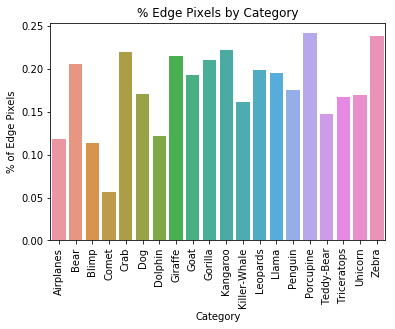

In [8]:
new_df_2 = train_df.groupby('class').agg('mean').reset_index()
sns.barplot(x = 'class', y = 'edge', data = new_df_2)
plt.xticks(range(len(category_list)), category_list, rotation = 90)
plt.xlabel('Category')
plt.ylabel('% of Edge Pixels')
plt.title('% Edge Pixels by Category')
plt.savefig("figs/edges.png", bbox_inches='tight')

We were originally uncertain as to whether to include the edge detection values because they seemed to be quite arbitrary for our different images. However, that hypothesis was proven wrong by the above plot, which shows a significant amount of variation by category, implying that it's a useful feature. One interesting point is that roughly speaking, the categories that have more edges are what we'd expect (animals like zebras and porcupines with many straight edges) indicating that even though our images have significant variation within a category, we're still seeing consistent trends that could be useful for our ML model. 

In [9]:
# B/W images with single channel.. keep to show for report
files=[]
for i,image in enumerate(starting_data["image"]):
    if len(image.shape) < 3:
        files.append(starting_data.loc[i, "filename"])
print(files)

[]


In [10]:
# Checking the min-max and counts of generated data to ensure no obvious outliers
train_df.describe()

,class,aspect,red,green,blue,argmax_r,argmax_g,argmax_b,contrast,edge,red_crop,green_crop,blue_crop,argmax__crop_r,argmax_crop_g,argmax_crop_b,contrast_crop,edge_crop
count,1501.00000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000
mean,9.57495,1.271221,118.674594,117.969340,109.286776,0.499332,0.232381,0.268287,241.695293,0.177471,116.009166,110.528402,101.724997,0.549550,0.186178,0.264272,229.225584,0.206349
std,5.54189,0.427860,44.630329,40.436065,45.336776,0.312321,0.242714,0.301192,20.051401,0.081838,41.266951,36.541116,41.342812,0.329501,0.219490,0.310755,28.169096,0.087418
min,0.00000,0.525397,1.106049,0.560478,3.824446,0.000000,0.000000,0.000000,50.916667,0.002747,1.067322,0.806227,6.372816,0.000000,0.000000,0.000000,42.500000,0.002686
25%,5.00000,0.918333,88.656294,92.409164,74.885923,0.230652,0.030273,0.018738,237.276774,0.118164,89.898811,87.577558,70.761315,0.261719,0.016602,0.010010,218.103882,0.147461
50%,9.00000,1.333333,117.803005,117.420675,105.316196,0.498779,0.146118,0.138184,249.582682,0.171936,117.124451,108.332845,95.893485,0.585449,0.092529,0.120117,237.810791,0.210449
75%,14.00000,1.500000,146.935043,142.000479,139.460025,0.763428,0.362305,0.427551,254.113444,0.240234,142.853776,132.894375,127.482779,0.852539,0.287598,0.445557,249.866933,0.268311
max,19.00000,3.469027,243.682848,242.976391,241.722951,1.000000,0.986145,1.000000,255.000000,0.375793,237.698004,235.436205,241.186424,1.000000,0.992920,1.000000,255.000000,1.000000


In [11]:
# Save the feature dataframe to a pickle compressed object to use in notebook 3
train_df.to_pickle("train_df_part2.pkl")
test_df.to_pickle("test_df_part2.pkl")

<h4> Sources </h4>

- [Medium blog : Feature extraction Machine Learning](https://medium.com/machine-learning-world/feature-extraction-and-similar-image-search-with-opencv-for-newbies-3c59796bf774)
- [OpenCV2 Python documentation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d)
- [Medium post : Simple animal classifier](https://medium.com/@divyanshuDeveloper/a-simple-animal-classifier-from-scratch-using-keras-61ef0edfcb1f)